In [1]:

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import cumfreq, ks_2samp, linregress
import bisect

Reading the water level data and do some preprocessing and formatting

In [2]:
water_level = pd.read_excel('WL_Sirajganj_1.xlsx')
# water_level['WL'] =water_level.iloc[:,3:5].WL(axis=1)

water_level['Date'] = pd.to_datetime(water_level['Date'])
water_level['Year'] = pd.DatetimeIndex(water_level['Date']).year
water_level['Month'] = pd.DatetimeIndex(water_level['Date']).month
water_level = water_level[water_level['Year']>=2012]
# water_level['Year-Month'] =  water_level['Year'].astype(str) + '-' + water_level['Month'].astype(str) #str(water_level['Year'])+'-'+str(water_level['Month'])

water_level_v1 = pd.DataFrame()

start =pd.DatetimeIndex (['2012-06-01','2013-06-01','2014-06-01','2015-06-01','2016-06-01','2017-06-01','2018-06-01','2019-06-01','2020-06-01','2021-06-01'])
end = pd.DatetimeIndex(['2013-05-31','2014-05-31','2015-05-31','2016-05-31','2017-05-31','2018-05-31','2019-05-31','2020-05-31','2021-05-31','2022-05-31'])

#water_level.describe()
for i in range(len(start)):
    temp = water_level[(water_level['Date']>=start[i]) & (water_level['Date']<= end[i])].copy()
    temp['HYear'] = str(pd.to_datetime(start[i]).year) + '/' + str(pd.to_datetime(end[i]).year)
    water_level_v1 = pd.concat([water_level_v1,temp], axis=0)
    
HYears =[]
for i in range(len(start)):
    #temp = water_level[(water_level['Date']>=start[i]) & (water_level['Date']<= end[i])] 
    h = str(pd.to_datetime(start[i]).year) + '/' + str(pd.to_datetime(end[i]).year)
    HYears.append(h)
   
   
water_level_v1

,Date,WL,Year,Month,HYear
2281,2012-06-01,10.09,2012,6,2012/2013
2282,2012-06-02,10.17,2012,6,2012/2013
2283,2012-06-03,10.23,2012,6,2012/2013
2284,2012-06-04,10.24,2012,6,2012/2013
2285,2012-06-05,10.26,2012,6,2012/2013
...,...,...,...,...,...
5838,2022-05-27,11.48,2022,5,2021/2022
5839,2022-05-28,11.28,2022,5,2021/2022
5840,2022-05-29,11.10,2022,5,2021/2022
5841,2022-05-30,10.92,2022,5,2021/2022


A class object to perform linear interpolation: to find exceedance probability for particular water level

In [3]:

class Interpolation:
    def __init__(self, depth_bins, bins_ep):
        '''
        Initialize the interpolation with depth bins and their exceedance probabilities.
        Args:
        depth_bins: Bins generated from histogram (sorted array).
        bins_ep: Exceedance probability of the bins.
        '''
              # Ensure the arrays are sorted by depth bins
        sorted_indices = np.argsort(depth_bins)
        self.depth_bins = np.array(depth_bins)[sorted_indices]
        self.bins_ep = np.array(bins_ep)[sorted_indices]

    def find_enclosing_indices(self, ref):
        '''
        Find indices of the depth bins that enclose the reference depth.
        Args:
        ref: Reference depth to find enclosing bins for.
        Returns:
        A tuple of indices for the enclosing bins.
        '''
        pos = bisect.bisect_right(self.depth_bins, ref)
        lower_idx = max(0, pos-1)
        upper_idx = min(len(self.depth_bins) - 1, pos)
        return (lower_idx, upper_idx)

    def interpolate(self, ref):
        '''
        Interpolate to find the exceedance probability at the reference depth.
        Args:
        ref: Reference depth for which exceedance probability is estimated.
        Returns:
        Interpolated exceedance probability.
        '''
        lower_idx, upper_idx = self.find_enclosing_indices(ref)
        lower_depth, upper_depth = self.depth_bins[lower_idx], self.depth_bins[upper_idx]
        lower_ep, upper_ep = self.bins_ep[lower_idx], self.bins_ep[upper_idx]
        
        # Handle the case where the reference depth matches one of the boundaries exactly
        if lower_depth == upper_depth:
            return lower_ep
        
        # Linear interpolation
        interpolated_ep = (lower_ep + (upper_ep - lower_ep) * (ref - lower_depth) / (upper_depth - lower_depth))
        
        # Clamping the result between 0 and 1
        interpolated_ep = max(0, min(1, interpolated_ep))
        return interpolated_ep



,5,6,7,8,9,10,11,12,13
2012/2013,0.997268,0.997268,0.780055,0.601093,0.508197,0.409836,0.373598,0.293716,0.071038
2013/2014,0.997268,0.997268,0.647541,0.536066,0.492350,0.394353,0.237705,0.172678,0.016145
2014/2015,0.996743,0.996743,0.872964,0.766558,0.543974,0.450959,0.352443,0.169381,0.057275
2015/2016,0.997275,0.782016,0.623978,0.551317,0.478474,0.391349,0.351109,0.237057,0.073842
2016/2017,0.997015,0.907463,0.714499,0.630846,0.548507,0.450149,0.388344,0.267662,0.050204
2017/2018,0.997268,0.997268,0.728597,0.606557,0.478597,0.435792,0.393443,0.306284,0.127049
2018/2019,0.997268,0.904372,0.666667,0.540073,0.477838,0.398907,0.314754,0.254098,0.038251
2019/2020,0.997275,0.997275,0.648501,0.500000,0.455223,0.387829,0.331744,0.198910,0.057221
2020/2021,0.997268,0.836066,0.618852,0.512568,0.469126,0.426913,0.386885,0.338798,0.200364
2021/2022,0.997268,0.819672,0.689891,0.612022,0.532787,0.421676,0.280738,0.163934,0.058402


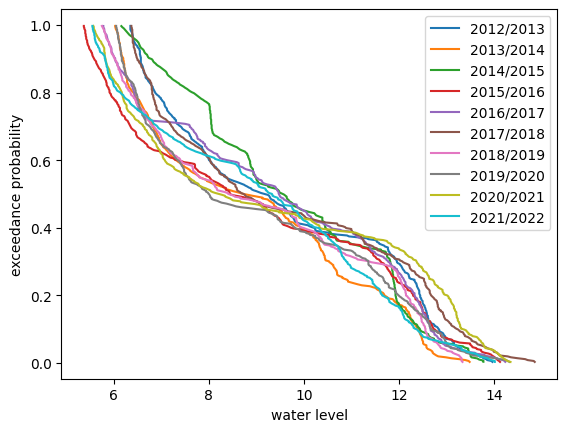

In [4]:
years = HYears #np.arange(2012,2023)
water_levels = np.arange(5,14,1)
exceedance_all_year = pd.DataFrame(columns=water_levels)


for year in years:

    #exceedance_all_year.index = years
    # year_yth = water_level[water_level['Year'] == year] 
    
    year_yth = water_level_v1[water_level_v1['HYear'] == year] 
    year_yth = year_yth.iloc[:,1:2]
    
    year_yth = year_yth.sort_values(by='WL',ascending=False,axis=0)
    
    year_yth['rank'] = np.arange(1,year_yth.shape[0]+1)
    year_yth['exceedance'] = year_yth['rank']/(year_yth.shape[0]+1)
    
    # getting data of the histogram 
    
    # count, bins_count = np.histogram(year_yth['WL'].values, bins=50)
    # print(year_yth)
    
    bins_count = year_yth['WL'].values

    # finding the PDF of the histogram using count values 
    # pdf = count / sum(count) 
    
    # using numpy np.cumsum to calculate the CDF 
    # exceedance = 1 - np.cumsum(pdf) 
    
    exceedance = year_yth['exceedance'].values
    # plotting PDF and CDF 
    #plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
    plt.plot(bins_count[:],exceedance, label=year) 
    plt.xlabel('water level')
    plt.ylabel('exceedance probability')
    plt.grid()
    plt.legend() 
    
    exceedance_prob = []

    inter = Interpolation(depth_bins=bins_count, bins_ep=exceedance)
    for element in water_levels:
        closing_indices = inter.find_enclosing_indices(element)
        # print(closing_indices)
        ep = inter.interpolate(ref = element)
        exceedance_prob.append(ep)


    exceedance_all_year.loc[len(exceedance_all_year)] = exceedance_prob

exceedance_all_year.index = years
#exceedance_all_year.to_excel('exceedance.xlsx')
exceedance_all_year

FREQUENCY ANALYSIS OF WATER LEVEL

In [13]:
years = HYears #np.arange(2012,2023)



def FreqAnalysis(year_yth, year,water_levels = np.arange(5,14.5,1), is_exceedance = False):
    exceedance_all_year = pd.DataFrame(columns=water_levels)
    year_yth = year_yth.iloc[:,1:2]
    
    year_yth = year_yth.sort_values(by='WL',ascending=False,axis=0)
    
    year_yth['rank'] = np.arange(1,year_yth.shape[0]+1)
    year_yth['exceedance'] = year_yth['rank']/(year_yth.shape[0]+1)
    
    # getting data of the histogram 
    # count, bins_count = np.histogram(year_yth['WL'].values, bins=50)
    # pd.DataFrame(year_yth).to_excel('exceedance_20182019.xlsx')
    
    bins_count = year_yth['WL'].values

    # finding the PDF of the histogram using count values 
    # pdf = count / sum(count) 
    # using numpy np.cumsum to calculate the CDF 
    # exceedance = 1 - np.cumsum(pdf) 
    
    exceedance = year_yth['exceedance'].values
    cdf = 1- exceedance
    # plotting PDF and CDF 
    #plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
    if is_exceedance:
        plt.plot(bins_count[:],exceedance, label=year) 
        plt.xlabel('water level (m PWD)')
        plt.ylabel('exceedance  proability')
        # plt.grid()
        plt.legend() 
    else:
        plt.plot(bins_count[:],cdf, label=year) 
        plt.xlabel('water level (m PWD)')
        plt.ylabel('cdf')
        # plt.grid()
        plt.legend()
    
    exceedance_prob = []

    inter = Interpolation(depth_bins=bins_count, bins_ep=exceedance)
    for element in water_levels:
        estimated_prob = inter.interpolate(element)
        exceedance_prob.append(estimated_prob)


    exceedance_all_year.loc[len(exceedance_all_year)] = exceedance_prob
    
    return exceedance_all_year

Sampling the images from low flow period to reduce skewness

In [6]:

def sampling(water_level, num_of_low_flow_samples,thres = 8):
    above_low = water_level[water_level['WL']>=thres]
    low = water_level[water_level['WL']<thres]
    low.copy().sort_values(by = 'Date', inplace= True)
    
    low_flow_dates =  pd.DataFrame(low['Date'])
    sorted_low_flow_dates = sorted(low_flow_dates.values.flatten())
    # print(len(sorted_low_flow_dates))
    # interval = len(sorted_low_flow_dates)//28
    # print(interval)
    if num_of_low_flow_samples > low.shape[0]:
        resampled_merged = water_level
    else:
        indices = np.linspace(0, low_flow_dates.shape[0]-1, num= num_of_low_flow_samples)
    
    # uniform_sample = [sorted_low_flow_dates[i*interval] for i in range(int(np.floor(len(sorted_low_flow_dates)/interval)))]
    # if len(sorted_low_flow_dates)%2 != 0:
    #     uniform_sample.append(sorted_low_flow_dates[-1])
        
    # uniform_sample = [np.datetime_as_string(d,unit='D') for d in uniform_sample]
        uniform_sample = low.iloc[indices]

    # uniform_sample = pd.to_datetime(uniform_sample)

    # sampled_low = low[low['Date'].isin(uniform_sample)]

        resampled_merged = pd.concat([above_low,uniform_sample],axis=0)
    return resampled_merged
 
    

Finding Optimum number of images to be selected from the available low flow period images. Optimum no. of sample is that no. which will make sure the parent cdf and sampled cdf are as close as possible. Kolmogorov-Smirnov test has been used to find the optimum value. This test is commonly use to check if two datasets have similar cdf.

In [8]:

def OptimumNumberOfSamples(parent_wl, child_wl, threshold):
    low_wl = child_wl[child_wl['WL']<threshold]
    optimization_space = np.arange(1,low_wl.shape[0],1)
    KS_STAT = []
    P_VALUE = []
    for n in optimization_space:
        resampled_wl = sampling(child_wl, n,threshold)
        
        cfreq_child = cumfreq(np.array(resampled_wl['WL']),numbins = resampled_wl.shape[0])
        cdf_child = cfreq_child.cumcount/resampled_wl.shape[0]
        
        cfreq_parent = cumfreq(np.array(parent_wl['WL']), numbins = parent_wl.shape[0])
        cdf_parent = cfreq_parent.cumcount/parent_wl.shape[0]
        # print(cdf_parent.shape, cdf_child.shape)
        
        ks_stat, p_val = ks_2samp(cdf_parent, cdf_child)
        KS_STAT.append(ks_stat)
        P_VALUE.append(p_val)
        # print(f'KS Stat:{ks_stat} P Value:{p_val}')
    optimum_no_of_sample = optimization_space[np.argmin(KS_STAT)]
    p_value_of_optimum = P_VALUE[np.argmin(KS_STAT)]
    min_ks_stat = min(KS_STAT)
    return (optimum_no_of_sample, min_ks_stat, p_value_of_optimum)
    # print(KS_STAT,np.argmin(KS_STAT),optimization_space[np.argmin(KS_STAT)])
        
    

Visualization and Analysis of Temporal Image Distribution and correcting the skewness

In [84]:
key = 'CloudFree'
ls8_id = 'LC08'
s1a_id = 'S1A'
s1b_id = 'S1B'
s2_id = 'T45QYG'

def which_satellite(system_index):
    if ls8_id in system_index:
        return 'Landsat 8'
    elif s1a_id in system_index:
        return 'Sentinel 1'
    elif s1b_id in system_index:
        return 'Sentinel 1'
    elif s2_id in system_index:
        return 'Sentinel 2'
    else:
        return 'Unknown'

def ImageDistribution(water_level_df= water_level_v1, yoi = None, resample = False,low_threshold = 8, high_threshold=12, is_exceedance = False, AreaWL = False, linear = False):
    year1 = str.split(yoi,sep='/')[0]
    year2 = str.split(yoi, sep='/')[1]
    pth = "ImagesDates/" + key + "_ImagesDate_" + year1 + '_' + year2 + '.csv'
    image_dates = pd.read_csv(pth)
     
    images_area = pd.read_csv( "ImagesDates/" + key + "_WaterSurfaceArea_" + year1 + '_' + year2 + '.csv').iloc[:,1:3]
    images_area['Date'] = pd.to_datetime(images_area['Date'])
    
    
    index_dates = image_dates.copy()
    index_dates.columns = ['system:index','Date','geo']
    index_dates['Satellite'] = index_dates['system:index'].apply(which_satellite)
    index_dates['Date'] = pd.to_datetime(index_dates['Date'	])
  
    image_dates = image_dates.iloc[:,1:2].values.flatten()
    image_dates = pd.to_datetime(image_dates)
    sub_water_level = water_level_v1[water_level_df["Date"].isin(image_dates)]
    
    sub_water_level = pd.merge(left= sub_water_level, right= index_dates,how='left',on='Date')
    sub_water_level = pd.merge(left= sub_water_level, right= images_area,how='left',on='Date')
    all_water_level = water_level_v1[water_level_df['HYear']== yoi]
    
    optimum_no_of_low_flow_images,ks_stat, p_stat = OptimumNumberOfSamples(parent_wl = all_water_level,child_wl = sub_water_level, threshold = low_threshold)
    print(f'Optimum no. of low flow image samples:{optimum_no_of_low_flow_images}\n KS-Stat: {ks_stat} \n P-value:{p_stat}')
    
    if resample:
        resampled_water_level = sampling(sub_water_level,num_of_low_flow_samples= optimum_no_of_low_flow_images)
    else:
        resampled_water_level = sub_water_level
        
    # print(resampled_water_level)
        
    ep1 = FreqAnalysis(year_yth=all_water_level,is_exceedance = is_exceedance,year = yoi+ ' All')
    ep2 = FreqAnalysis(year_yth=sub_water_level,is_exceedance = is_exceedance, year = yoi + ' Images')
    if resample:
        ep3 = FreqAnalysis(year_yth= resampled_water_level,is_exceedance = is_exceedance, year = yoi +' Resampled')
        count_resampled_dry_images = resampled_water_level[resampled_water_level['WL']<low_threshold].shape[0]
        # print(pd.DataFrame(ep3))
        
        if linear:
            x1 = ep3.columns[0]
            y1 = ep3.iloc[:1,:].values.flatten()[0]
            x2 = ep3.columns[-1]
            y2 = ep3.iloc[:1,:].values.flatten()[-1]
            slope = (y2-y1)/(x2-x1)
            linear_wop =[(slope * (x-x1)) + y1 for x in ep3.columns]
            linear_wop = pd.DataFrame([linear_wop], columns= ep3.columns)
            ep3 = pd.concat([ep3,linear_wop]).T
            ep3.columns = ['excd prob water', 'linear wop']
            
        pd.DataFrame(ep3).T.to_csv(f'wl_exceedance_probability_{year1}_{year2}_wop_linear.csv')
    else:
        count_resampled_dry_images = 'NA'

    total_images = sub_water_level.shape[0]
    count_dry_images = sub_water_level[sub_water_level['WL']<low_threshold].shape[0]
    count_wet_images = sub_water_level[sub_water_level['WL']>high_threshold].shape[0]
    # print(resampled_water_level)


    satellite_colors = {
        'Landsat 8': 'green',  
        'Sentinel 1': 'black',  
        'Sentinel 2': 'blue'  
        }
    fig = plt.figure(figsize=(12,6))

    plt.scatter(sub_water_level['Date'],sub_water_level['WL'],c='red',marker= '*',s=60, label = 'image available', zorder = 2)
    if resample:
        # plt.scatter(resampled_water_level['Date'],resampled_water_level['WL'], c='black',marker= '.',s =30, label = 'resample',zorder =3)
        sns.scatterplot(data= resampled_water_level, x= 'Date', y = 'WL',s= 15, hue='Satellite',palette=satellite_colors,zorder = 3)
    plt.plot(all_water_level['Date'],all_water_level['WL'], label= 'water level',zorder = 1)
    plt.axhline(y=8, color = 'grey', alpha = 0.5,linestyle = ':')
    plt.axhline(y = 12, color = 'blue', alpha = 0.5, linestyle = ":")
    plt.text(0.25, 0.17,f'No. of low flow images: {count_dry_images} ({(count_dry_images/total_images *100).__round__(2)}%) \n [Resampled to {count_resampled_dry_images}] ',horizontalalignment='center',verticalalignment='center', transform = plt.gca().transAxes)
    plt.text(0.6,0.8,f'No. of high flow images: {count_wet_images} ({(count_wet_images/total_images*100).__round__(2)}%)',ha = 'center', va = 'center', transform = plt.gca().transAxes)
    plt.text(0.6,0.6, f'Total no. of images: {total_images}',ha = 'center',va = 'center', transform = plt.gca().transAxes)
    plt.xlabel('date')
    plt.ylabel('water level (m PWD)')
    plt.legend(loc='upper right')
    
    if AreaWL:
        fig1 = plt.figure(figsize= (12,6))
        area_wl = resampled_water_level[['Area','WL']]
        
        slope, intercept, r_value, p_value, std_err = linregress(area_wl['WL'], area_wl['Area'])
        
        
        sns.regplot(data= area_wl, x='WL',y = 'Area', scatter_kws={ 's' : 15}, ci = None, line_kws={'color': 'grey', 'linestyle':'--','linewidth': 1})
        plt.xlabel('water level (m PWD)')
        plt.ylabel('area (sq. km)')
        
        # Annotate the plot with the R^2 value
        plt.text(x=max(area_wl['WL']), y=min(area_wl['Area']), s=f'$R^2$: {r_value**2:.2f} \n P-value: {p_value.__round__(4)}', 
                horizontalalignment='right', verticalalignment='bottom', fontsize=12, color='green')

        
        
    return ep3
    




Optimum no. of low flow image samples:34
 KS-Stat: 0.09951512352805357 
 P-value:0.559160153268962


,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
excd prob water,0.986111,0.986111,0.634259,0.525794,0.46250,0.364130,0.308140,0.154820,0.057292,0.029251
linear wop,0.986111,0.879793,0.773475,0.667158,0.56084,0.454522,0.348204,0.241886,0.135569,0.029251


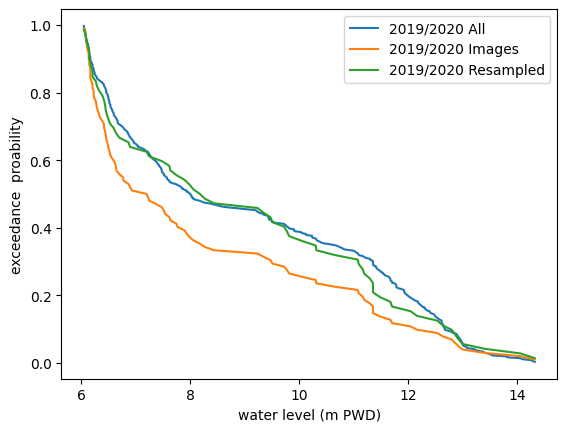

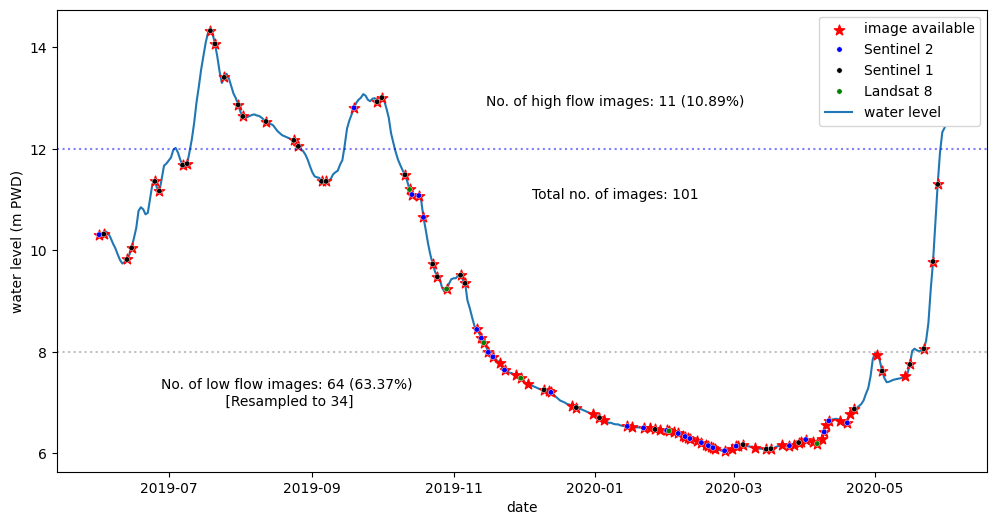

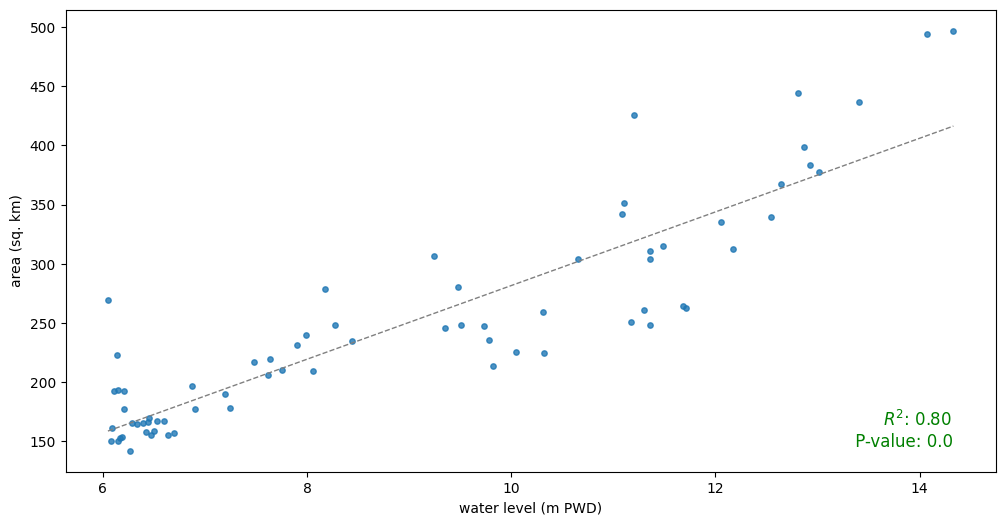

In [85]:
    
resampled_2019_2020 = ImageDistribution(yoi='2019/2020',resample= True,is_exceedance= True, AreaWL= True, linear = True)  #cloud-free:35, cloud-inferred: 55
# resampled_2019_2020.sort_values(by = 'Date').to_csv('Resampled_'+key+'_ImagesDate_2019_2020.csv',index= False)
resampled_2019_2020.T



Optimum no. of low flow image samples:31
 KS-Stat: 0.08454011741682975 
 P-value:0.7593561246812396
       5.0      6.0       7.0       8.0       9.0       10.0      11.0  \
0  0.985915  0.81338  0.632394  0.551056  0.482665  0.427817  0.383264   

       12.0      13.0      14.0  
0  0.328512  0.213539  0.071831  


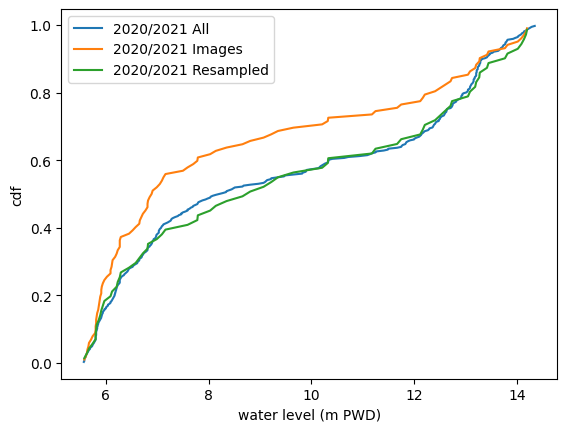

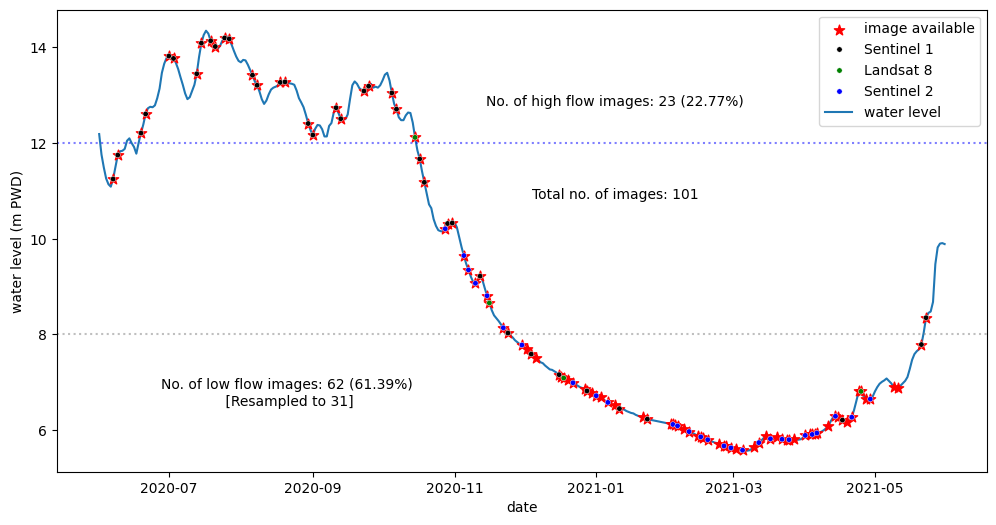

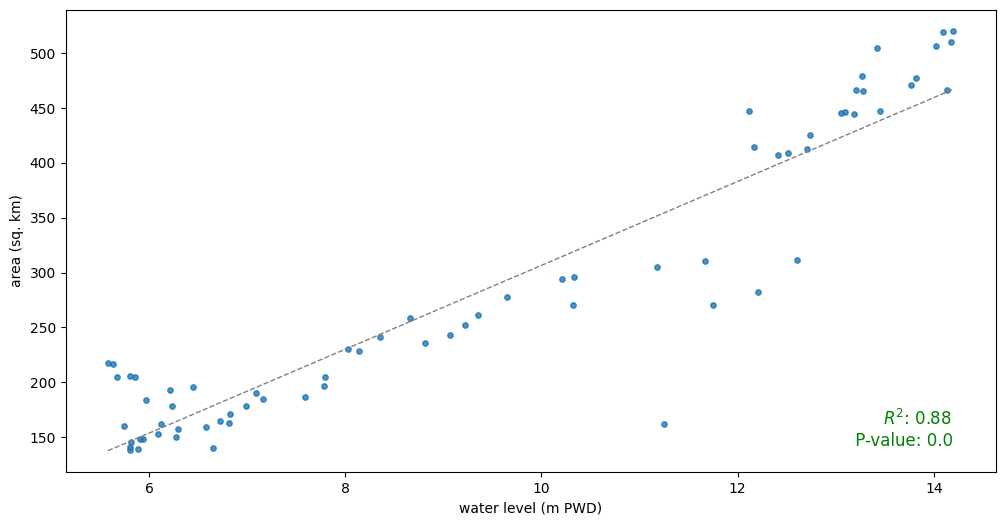

In [11]:
    
resampled_2020_2021 = ImageDistribution(yoi='2020/2021',resample= True, AreaWL= True)  #cloud-free:33 cloud-inferred: 60
# resampled_2020_2021.sort_values(by = 'Date').to_csv('Resampled_'+key+'_ImagesDate_2020_2021.csv',index= False)


Optimum no. of low flow image samples:41
 KS-Stat: 0.053283830495455126 
 P-value:0.9606069544897107
       5.0       6.0       7.0       8.0       9.0       10.0      11.0  \
0  0.990741  0.822531  0.701389  0.611111  0.567901  0.432099  0.254321   

       12.0      13.0      14.0  
0  0.152778  0.070473  0.010494  


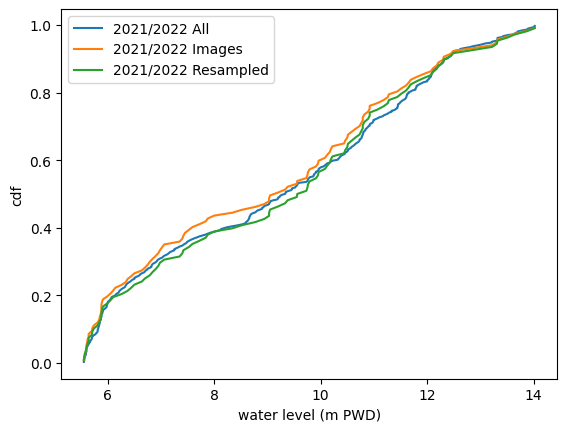

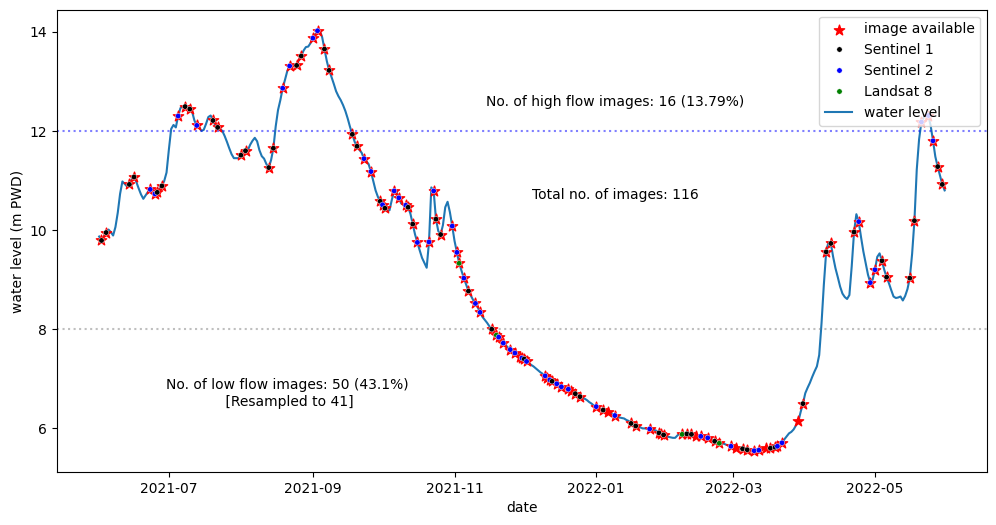

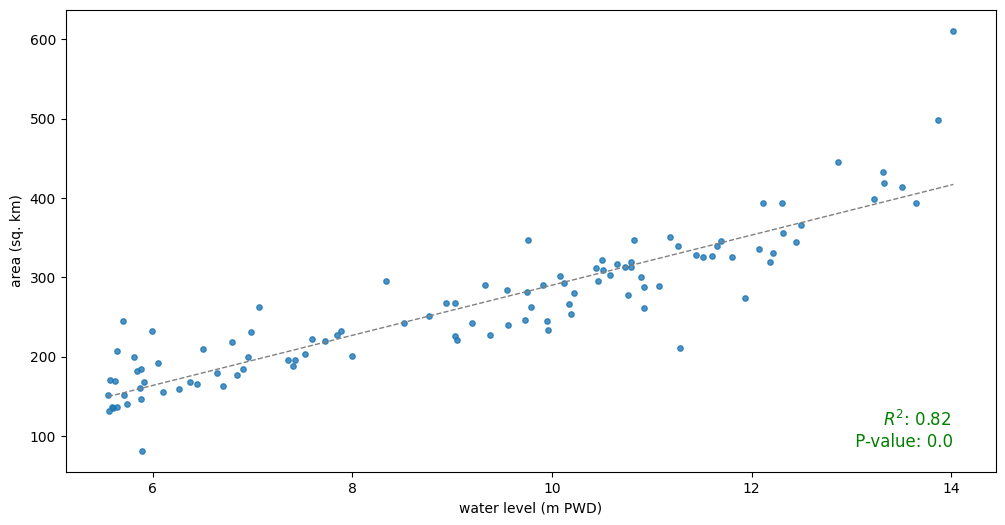

In [107]:
    
resampled_2021_2022 = ImageDistribution(yoi='2021/2022',resample= True, AreaWL= True) #cloud-free:30,cloud-inferred:44
# resampled_2021_2022.sort_values(by = 'Date').to_csv('Resampled_'+key+'_ImagesDate_2021_2022.csv',index= False)